In [61]:
import os, sys, json, asyncio
from langgraph.graph import START, END, StateGraph
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field
from typing import List, Optional, Dict

In [62]:
from dotenv import load_dotenv

load_dotenv("./.env.local")

GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", None)

if GEMINI_API_KEY is None:
    print("Key not registered")

In [63]:
from med_search_service import MedicineSearchService, Location, AvailableMedStores, Drug
from prescription_extraction_service import PrescriptionExtractor

In [64]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GEMINI_API_KEY,
)

Data classes


In [65]:
class ExtractedMedicine(BaseModel):
    name: str = Field(
        description="Medicine name exactly as written in the prescription"
    )

    normalized_name: Optional[str] = Field(
        default=None,
        description="Standardized or generic drug name without dosage or strength",
    )

    strength: Optional[str] = Field(
        default=None, description="Dosage strength (e.g., '500 mg', '10 ml')"
    )

    dosage_form: Optional[str] = Field(
        default=None, description="Dosage form (e.g., tablet, syrup, capsule)"
    )

    quantity: Optional[int] = Field(
        default=None,
        description="Total number of units prescribed (e.g., tablets count)",
    )

    frequency: Optional[str] = Field(
        default=None,
        description="How often the medicine should be taken (e.g., 'twice daily')",
    )

    duration: Optional[str] = Field(
        default=None, description="Duration of treatment (e.g., '2 days')"
    )

    confidence: Optional[float] = Field(
        default=None, ge=0.0, le=1.0, description="Extraction confidence score"
    )


class PrescribedMeds(BaseModel):
    medicines: List[ExtractedMedicine] = Field(
        description="List of medicine names exactly as mentioned in the prescription"
    )

In [66]:
class DosageInstruction(BaseModel):
    name: str = Field(
        description="Medicine name exactly as written in the prescription"
    )

    strength: Optional[str] = Field(
        default=None,
        description="Dosage strength (e.g., '500 mg', '10 ml')",
    )

    dosage_form: Optional[str] = Field(
        default=None,
        description="Dosage form (e.g., tablet, capsule, syrup)",
    )

    frequency: Optional[str] = Field(
        default=None,
        description="How often the medicine should be taken (e.g., 'twice daily')",
    )

    duration: Optional[str] = Field(
        default=None,
        description="Duration of treatment (e.g., '5 days')",
    )

    quantity: Optional[int] = Field(
        default=None,
        description="Total quantity prescribed, if explicitly mentioned",
    )

    instruction: str = Field(
        description="Clear, patient-friendly instruction on how to take the medicine",
    )

In [67]:
class ProcessState(BaseModel):
    input_image: str
    user_location: Location

    dosage_instructions: Optional[List[DosageInstruction]] = Field(
        None,
        description="Data structure containting the dosage instructions for each medicine prescribed",
    )
    prescribed_meds: Optional[PrescribedMeds] = Field(
        None,
        description="Medicines extracted from the prescription, including original names and normalized equivalents.",
    )

    available_meds: Optional[dict] = Field(
        None,
        description=(
            "Availability results grouped by store and medicine,mapping each store to the list of matching products returned by pharmacy searches."
        ),
    )

    rx_text: Optional[str] = Field(
        None, description="Prescrption text extracted by the model"
    )

    final_output: Optional[Dict]

LangGraph


In [68]:
def extract_prescription(state: ProcessState) -> dict:
    """Extracts the prescrption from the provided input image"""
    rx_text = PrescriptionExtractor.extract(state.input_image)
    return {"rx_text": rx_text}

In [69]:
async def extract_prescribed_meds(state: ProcessState) -> dict:

    prompt = PromptTemplate(
        template="""
  You are a medical text extraction agent.

  TASK:
  Extract medicines from the prescription text and structure them according to the provided schema.

  RULES:
  - Extract ONLY medicines explicitly mentioned in the text.
  - Do NOT add, infer, or guess any medicines.
  - Preserve the original wording in the "name" field.
  - Fill other fields ONLY if the information is explicitly present.
  - If a field is not mentioned, return null for that field.
  - Do NOT normalize unless it is obvious (e.g., Paracetamol 500 mg → Paracetamol).
  - Do NOT include explanations or extra text.
  - If no medicines are found, return an empty list.

  PRESCRIPTION TEXT:
  {prescription_text}
  """,
        input_variables=["prescription_text"],
    )

    chain = prompt | model.with_structured_output(PrescribedMeds)
    result = await chain.ainvoke({"prescription_text": state.rx_text})
    return {"prescribed_meds": result}

In [70]:
async def fetch_available_meds(state: ProcessState) -> dict:
    """
    Fetch available medicines from all selected stores.

    Output shape:
    {
        store -> {
            medicine_name -> List[Drug]
        }
    }
    """

    async def _search(store, required_med: ExtractedMedicine):
        meds = await MedicineSearchService.search(
            store,
            drug_name=required_med.normalized_name or required_med.name,
            location=state.user_location,
        )
        return store, required_med.name, meds

    tasks = [
        _search(store, required_med)
        for store in AvailableMedStores.list_all()
        for required_med in state.prescribed_meds.medicines  # type: ignore
    ]

    results = await asyncio.gather(*tasks)

    store_map: Dict[str, Dict[str, List[Drug]]] = {}

    for store, med_name, drugs in results:
        store_key = store.name if hasattr(store, "name") else str(store)

        store_map.setdefault(store_key, {})
        store_map[store_key][med_name] = drugs

    return {"available_meds": store_map}

In [71]:
async def make_dosage_chart(state: ProcessState) -> dict:
    """
    Uses the LLM to generate clear instructions for each medicine
    based strictly on extracted fields.
    """

    prompt = PromptTemplate(
        template="""
You are a medical instruction generator.

TASK:
For the given medicine details, write a clear, patient-friendly instruction
on how to take the medicine.

RULES:
- Use ONLY the provided information.
- Do NOT guess or add missing details.
- Do NOT change the medicine name.
- If a field is missing, simply omit it from the instruction.
- Keep the instruction short and clear.
- Do NOT include warnings or side effects.

MEDICINE DETAILS:
Name: {name}
Strength: {strength}
Dosage form: {dosage_form}
Frequency: {frequency}
Duration: {duration}
Quantity: {quantity}

Return ONLY the instruction text.
""",
        input_variables=[
            "name",
            "strength",
            "dosage_form",
            "frequency",
            "duration",
            "quantity",
        ],
    )

    chain = prompt | model | StrOutputParser()

    async def _generate_instruction(med: ExtractedMedicine) -> dict:
        instruction = await chain.ainvoke(
            {
                "name": med.name,
                "strength": med.strength,
                "dosage_form": med.dosage_form,
                "frequency": med.frequency,
                "duration": med.duration,
                "quantity": med.quantity,
            }
        )

        return {
            "name": med.name,
            "normalized_name": med.normalized_name,
            "strength": med.strength,
            "dosage_form": med.dosage_form,
            "frequency": med.frequency,
            "duration": med.duration,
            "quantity": med.quantity,
            "instruction": instruction.strip(),
            "confidence": med.confidence,
        }

    tasks = [
        _generate_instruction(med)
        for med in state.prescribed_meds.medicines  # type: ignore
    ]

    dosage_instructions = await asyncio.gather(*tasks)

    return {"dosage_instructions": dosage_instructions}

In [72]:
async def summarize(state: ProcessState) -> dict:
    """
    Final summary builder:
    - For each store, selects best suited available drug per prescribed medicine
    - Preserves original prescribed medicine name
    - Includes price, image, and URL
    """

    selection_prompt = PromptTemplate(
        template="""
You are selecting the best suited available drug for a prescribed medicine.

RULES:
- Select ONLY ONE option.
- Prefer medicines that are AVAILABLE.
- Prefer lower price if equally suitable.
- Prefer closest name / molecule match.
- Do NOT explain your choice.
- Return ONLY the index number (0-based).

PRESCRIBED MEDICINE:
{prescribed_name}

AVAILABLE OPTIONS:
{options}
""",
        input_variables=["prescribed_name", "options"],
    )

    selection_chain = selection_prompt | model | StrOutputParser()

    store_summaries = {}

    async def _select_for_store(store, dosage, options):
        options_text = "\n".join(
            f"{i}. {d.name} | price={d.sale_price or d.mrp} | available={d.available}"
            for i, d in enumerate(options)
        )

        idx_str = await selection_chain.ainvoke(
            {
                "prescribed_name": dosage.name,
                "options": options_text,
            }
        )

        try:
            idx = int(idx_str.strip())
            return store, dosage, options[idx]
        except Exception:
            return None

    tasks = []

    for store, meds_map in (state.available_meds or {}).items():
        for dosage in state.dosage_instructions:  # type: ignore
            options = meds_map.get(dosage.name) or []
            if options:
                tasks.append(_select_for_store(store, dosage, options))

    results = await asyncio.gather(*tasks)

    for result in results:
        if not result:
            continue

        store, dosage, best = result

        store_summaries.setdefault(store, [])
        store_summaries[store].append(
            {
                "prescribed_medicine": dosage.name,
                "selected_drug": {
                    "name": best.name,  
                    "price": best.sale_price or best.mrp,
                    "mrp": best.mrp,
                    "image": best.image,
                    "url": best.url,
                },
            }
        )

    instructions = [
        {
            "medicine": d.name,
            "instruction": d.instruction,
        }
        for d in state.dosage_instructions  # type: ignore
    ]

    return {
        "final_output": {
            "stores": store_summaries,
            "instructions": instructions,
        }
    }

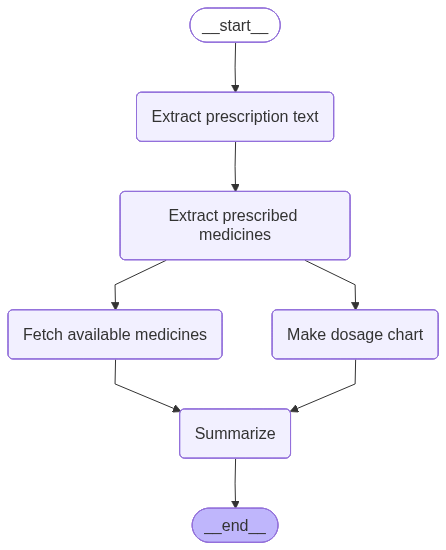

In [73]:
# Add available drug simultaneously using the prescribed meds
# "./sample-prescription.png",

checkpointer = InMemorySaver()

graph = StateGraph(ProcessState)

EXTRACT_PRESCRIPTION = "Extract prescription text"
EXTRACT_PRESCRIBED_MEDS = "Extract prescribed medicines"
FETCH_AVAILABLE_MEDS = "Fetch available medicines"
MAKE_DOSAGE_CHART = "Make dosage chart"
SUMMARIZER = "Summarize"

graph.add_node(EXTRACT_PRESCRIPTION, extract_prescription)
graph.add_node(EXTRACT_PRESCRIBED_MEDS, extract_prescribed_meds)
graph.add_node(FETCH_AVAILABLE_MEDS, fetch_available_meds)
graph.add_node(MAKE_DOSAGE_CHART, make_dosage_chart)
graph.add_node(SUMMARIZER, summarize)

graph.add_edge(START, EXTRACT_PRESCRIPTION)
graph.add_edge(EXTRACT_PRESCRIPTION, EXTRACT_PRESCRIBED_MEDS)
graph.add_edge(EXTRACT_PRESCRIBED_MEDS, FETCH_AVAILABLE_MEDS)
graph.add_edge(EXTRACT_PRESCRIBED_MEDS, MAKE_DOSAGE_CHART)

graph.add_edge(MAKE_DOSAGE_CHART, SUMMARIZER)
graph.add_edge(FETCH_AVAILABLE_MEDS, SUMMARIZER)

graph.add_edge(SUMMARIZER, END)

workflow = graph.compile(checkpointer=checkpointer)
workflow

In [74]:
init_state = ProcessState(
    input_image="./sample-prescription.png",
    user_location=Location(),
    prescribed_meds=None,
    available_meds=None,
    rx_text=None,
    dosage_instructions=None,
    final_output=None,
)

In [75]:
result = await workflow.ainvoke(
    init_state,
    config=RunnableConfig(
        configurable={
            "thread_id": "rx-session-001",
        }
    ),
)

In [76]:
result["final_output"]

{'stores': {'PHARMEASY': [{'prescribed_medicine': 'Amoxicillin 500 mg',
    'selected_drug': {'name': 'Almox 500mg Strip Of 15 Capsules',
     'price': 100.78,
     'mrp': 115.84,
     'image': 'https://cdn01.pharmeasy.in/dam/productsnowatermark/368178/almox-500mg-strip-of-15-capsules-side-6.01-1756922335-non-watermarked.jpg',
     'url': 'https://pharmeasy.in/online-medicine-order/almox-500mg-strip-of-15-capsules-188713'}},
   {'prescribed_medicine': 'Ibuprofen 200 mg',
    'selected_drug': {'name': 'Brufen 200mg Strip Of 15 Tablets',
     'price': 10.73,
     'mrp': 11.3,
     'image': 'https://cdn01.pharmeasy.in/dam/productsnowatermark/029720/brufen-200mg-strip-of-15-tablets-box-front-1-1756894190-non-watermarked.jpg',
     'url': 'https://pharmeasy.in/online-medicine-order/brufen-200mg-tablet-38361'}},
   {'prescribed_medicine': 'Omeprazole 20 mg',
    'selected_drug': {'name': 'Omez Insta 20mg Mint Flavour Sachet Of 5.9gm Oral Powder',
     'price': 15.68,
     'mrp': 16.17,
     

> What comes next? At this stage, this is not truly agentic AI it's primarily an LLM-driven pipeline with structured chaining. To move toward an agentic system, we would introduce a chatbot layer that can dynamically decide actions, register tools such as setting reminders, and perform additional drug lookups beyond the initially extracted medicines.

FastAPI endpoint to poll workflow state
```python
@app.get("/workflow/status/{thread_id}")
def get_workflow_status(thread_id: str):
    state = workflow.get_state(thread_id)

    return {
        "current_step": state.values.get("current_step"),
        "progress": state.values.get("progress"),
        "done": state.is_finished,
    }
```